## NOTE : For running this notebook you should download the dataset from :
###    https://www.kaggle.com/datasets/nomihsa965/traffic-signs-dataset-mapillary-and-dfg
##    and then put it in the main directory (Argos/) by "data" naming

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
import random


In [2]:
import json
import logging
import os
from collections import defaultdict
import random
from functools import cache

import torch
from PIL import Image
from torch.utils.data import Subset
from torchvision.transforms import transforms


def extract_label_mapping(classes_file):
    label_map = {}
    try:
        with open(classes_file, 'r') as f:
            json_data = json.load(f)
            for class_name, details in json_data.items():
                if "classIndex" in details:
                    label_map[details["classIndex"]] = class_name
    except FileNotFoundError:
        print(f"Error: Classes file not found at {classes_file}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {classes_file}. Check file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return label_map


class MTSDDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            root_dir,
            images_dir="images",
            annotations_dir="txts (YOLO)",
            transform=transforms.Compose([transforms.ToTensor()])
    ):

        self.root_directory = root_dir
        self.transform = transform

        self.images_names = sorted(
            os.listdir(
                os.path.join(self.root_directory, images_dir)
            )
        )
        self.full_images_directory = os.path.join(self.root_directory, images_dir)
        self.full_annotations_directory = os.path.join(self.root_directory, annotations_dir)

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        file_name = self.images_names[idx]

        img_path = os.path.join(self.full_images_directory, file_name)
        ann_path = os.path.join(self.full_annotations_directory, file_name[:-4] + '.txt')

        #print(img_path)

        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        img_tensor = self.transform(img)

        objects = []
        try:
            with open(ann_path, 'r') as f:
                for row in f.readlines():
                    objects.append(row.split())
        except FileNotFoundError:
            logging.warning(f"File {ann_path} not found.")
            pass
        # print(objects)

        boxes = []
        labels = []
        for obj in objects:
            # YOLO format: [class_id, x_center, y_center, width, height] (all normalized)
            class_id, cx, cy, bw, bh = map(float, obj)
            xmin = (cx - bw / 2) * w
            ymin = (cy - bh / 2) * h
            xmax = (cx + bw / 2) * w
            ymax = (cy + bh / 2) * h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }


        return img_tensor, target



In [3]:
dataset_path = "/kaggle/input/traffic-signs-dataset-mapillary-and-dfg/"
classes_json_file = os.path.join(dataset_path, "classes.json")

In [4]:
from torch.utils.data import Subset

dataset = MTSDDataset(dataset_path)
len(dataset)

19346

In [5]:
dataset = Subset(dataset , indices=list(range(1000)))
print(len(dataset))

1000


In [6]:
# Filter out indices with no boxes
valid_indices = []
for idx in range(len(dataset)):
    _, target = dataset[idx]
    if target["boxes"].numel() > 0:
        valid_indices.append(idx)

# Create cleaned dataset
clean_dataset = Subset(dataset, valid_indices)

print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset size: {len(clean_dataset)}")

Original dataset size: 1000
Filtered dataset size: 998


In [7]:
dataset = clean_dataset

In [8]:

label_mapping = extract_label_mapping(classes_json_file)

In [9]:
len(dataset)

998

In [10]:
dataset[2]

(tensor([[[0.6824, 0.6745, 0.6667,  ..., 0.7020, 0.7098, 0.7137],
          [0.6353, 0.6392, 0.6431,  ..., 0.7020, 0.7098, 0.7098],
          [0.6196, 0.6275, 0.6392,  ..., 0.7059, 0.7059, 0.7098],
          ...,
          [0.9765, 0.9765, 0.9765,  ..., 0.4039, 0.4000, 0.4039],
          [0.9765, 0.9765, 0.9765,  ..., 0.3882, 0.3922, 0.3922],
          [0.9765, 0.9765, 0.9765,  ..., 0.4078, 0.4118, 0.4000]],
 
         [[0.8000, 0.7922, 0.7843,  ..., 0.8157, 0.8235, 0.8275],
          [0.7529, 0.7569, 0.7608,  ..., 0.8157, 0.8235, 0.8235],
          [0.7373, 0.7451, 0.7569,  ..., 0.8196, 0.8196, 0.8235],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.4314, 0.4275, 0.4314],
          [1.0000, 1.0000, 1.0000,  ..., 0.4157, 0.4196, 0.4196],
          [1.0000, 1.0000, 1.0000,  ..., 0.4353, 0.4392, 0.4275]],
 
         [[0.9412, 0.9333, 0.9255,  ..., 0.9412, 0.9490, 0.9529],
          [0.8941, 0.8980, 0.9020,  ..., 0.9412, 0.9490, 0.9490],
          [0.8784, 0.8863, 0.8980,  ...,

In [11]:

def draw_sample(dataset, label_map=label_mapping):
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]
    image = F.to_pil_image(image)
    boxes = target['boxes']
    labels = target['labels']

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box.tolist()
        label = labels[i].item()
        class_name = label_map[label] if label_map else str(label)

        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            xmin, ymin - 4, class_name,
            color='red', fontsize=10, weight='bold'
        )

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

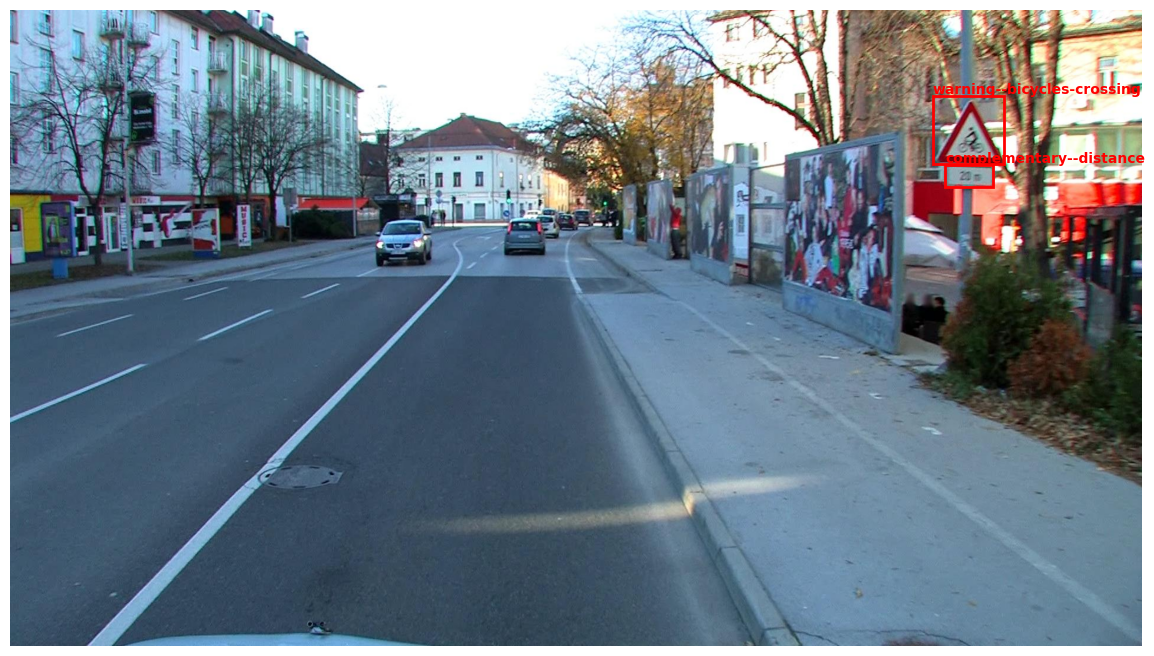

In [12]:
draw_sample(dataset)

## DataLoader

In [13]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [14]:
from torch import mps , cuda
import torch


def device_allocation():
    if mps.is_available():
        return torch.device("mps")
    elif cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")




## Training Faster R-CNN model

In [15]:
DEVICE = device_allocation()

In [16]:
import torchvision
from torchvision import ops
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from tqdm import tqdm
import os


def get_model(num_classes, checkpoint_path=None, device=DEVICE):
    """
    Returns a Faster R-CNN model with the specified number of output classes.

    Args:
        num_classes (int): Number of object classes (including background).
        checkpoint_path (str, optional): Path to load pretrained weights (optional).

    Returns:
        model (torch.nn.Module): Faster R-CNN model ready for training.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one for our custom classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print(f"Loaded model weights from: {checkpoint_path}")

    return model.to(device)



def train(model, dataloader, optimizer, epoch, checkpoint_dir=None, device=DEVICE):
    """
    Trains Faster R-CNN model for one epoch and optionally saves a checkpoint.

    Args:
        model (torch.nn.Module): The Faster R-CNN model.
        dataloader (DataLoader): PyTorch DataLoader returning (images, targets).
        optimizer (torch.optim.Optimizer): Optimizer (e.g., SGD).
        epoch (int): Current epoch number (used in checkpoint filename).
        checkpoint_dir (str, optional): Directory to save model checkpoints.
        device (torch.device): Device to train on ("cuda" or "cpu").

    Returns:
        avg_loss (float): Average loss over the epoch.
    """
    model.train()
    model.to(device)
    total_loss = 0.0
    num_batches = len(dataloader)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)

    for batch_idx, (images, targets) in enumerate(pbar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}", batch=f"{batch_idx+1}/{num_batches}")

    avg_loss = total_loss / num_batches

    # Save checkpoint
    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"fasterrcnn_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
        print(f"[✓] Saved checkpoint to {checkpoint_path}")

    return avg_loss




In [27]:
def evaluate(model, dataloader, device=DEVICE, iou_threshold=0.5):
    """
    Evaluate a Faster R-CNN model on a dataset.
    
    Computes only IoU-based accuracy (no loss).

    Args:
        model (torch.nn.Module): Trained Faster R-CNN model.
        dataloader (DataLoader): Validation/test DataLoader.
        device (torch.device): "cuda" or "cpu".
        iou_threshold (float): IoU threshold for counting correct detections.

    Returns:
        accuracy (float): Detection accuracy based on IoU.
    """
    model.eval()
    model.to(device)

    correct_detections = 0
    total_targets = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # skip samples with no ground-truth boxes
            if any(t['boxes'].numel() == 0 for t in targets):
                continue

            # get predictions only
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"]
                gt_boxes   = target["boxes"]

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    continue

                ious = ops.box_iou(pred_boxes, gt_boxes)
                max_iou_per_gt, _ = ious.max(dim=0)

                correct_detections += (max_iou_per_gt > iou_threshold).sum().item()
                total_targets      += len(gt_boxes)

    accuracy = correct_detections / total_targets if total_targets > 0 else 0.0
    return accuracy


In [18]:
len(label_mapping)

76

In [19]:
model = get_model(num_classes=len(label_mapping))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 185MB/s]  


In [20]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
from torch.optim import SGD


optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5

train_losses = []
val_losses = []
val_accuracies = []

In [22]:
from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train(model, train_loader, optimizer,epoch=epoch,checkpoint_dir="/kaggle/working", device=DEVICE)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # val_loss, val_accuracy = evalua(model, val_loader, device=DEVICE)
    # val_losses.append(val_loss)
    # val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")



Epoch 1/5


[✓] Saved checkpoint to /kaggle/working/fasterrcnn_epoch_0.pth
Training Loss: 0.3670

Epoch 2/5


[✓] Saved checkpoint to /kaggle/working/fasterrcnn_epoch_1.pth
Training Loss: 0.2612

Epoch 3/5


[✓] Saved checkpoint to /kaggle/working/fasterrcnn_epoch_2.pth
Training Loss: 0.2170

Epoch 4/5


[✓] Saved checkpoint to /kaggle/working/fasterrcnn_epoch_3.pth
Training Loss: 0.1844

Epoch 5/5


[✓] Saved checkpoint to /kaggle/working/fasterrcnn_epoch_4.pth
Training Loss: 0.1691


In [23]:
def evaluate(model, dataloader, device=DEVICE, iou_threshold=0.5):
    """
    Evaluate a Faster R-CNN model on a dataset.

    Args:
        model (torch.nn.Module): Trained Faster R-CNN model.
        dataloader (DataLoader): Validation/test dataloader.
        device (torch.device): "cuda" or "cpu".
        iou_threshold (float): IoU threshold for counting correct detections.

    Returns:
        avg_loss (float): Average loss on dataset.
        accuracy (float): Detection accuracy based on IoU.
    """
    model.eval()
    model.to(device)

    total_loss = 0.0
    num_batches = len(dataloader)
    correct_detections = 0
    total_targets = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)

        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                gt_boxes = target['boxes']
                gt_labels = target['labels']

                total_targets += len(gt_boxes)

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    continue

                ious = ops.box_iou(pred_boxes, gt_boxes)

                max_iou_per_gt, matched_preds = ious.max(dim=0)
                correct = (max_iou_per_gt > iou_threshold).sum().item()
                correct_detections += correct

    avg_loss = total_loss / num_batches
    accuracy = correct_detections / total_targets if total_targets > 0 else 0.0

    return avg_loss, accuracy


In [29]:
test_accuracy = evaluate(model=model , dataloader = val_loader)
print(f"test accuracy is : {test_accuracy}")

test accuracy is : 0.8949152542372881
